<a href="https://colab.research.google.com/github/RinaldoMancosu/Progetto_pytorch/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **PROGETTO DATA VISUALIZATION**

In [1]:
%matplotlib inline

# Clona la repository git hub contenente i vari Dataset
!git clone https://github.com/RinaldoMancosu/Dataset.git

Cloning into 'Dataset'...
remote: Enumerating objects: 30314, done.
remote: Counting objects: 100% (10266/10266), done.
remote: Compressing objects: 100% (10244/10244), done.
remote: Total 30314 (delta 20), reused 10266 (delta 20), pack-reused 20048
Receiving objects: 100% (30314/30314), 7.46 GiB | 17.89 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (31201/31201), done.


In [2]:
# import delle librerie necessarie
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Controlla se il dispositivo ha una GPU con cuda, altrimenti utilizza la cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118
cuda:0


# **INIZIALIZZAZIONE E DEFINIZIONE DEI MODELLI**

In [3]:
#Si salva in data_dir il dataset che si andrà ad utilizzare
data_dir_1 = "Dataset/Skybox"
data_dir_2 = "Dataset/Skybox_colore"
data_dir_3 = "Dataset/Skybox-Colore_oggetto"
data_dir_4 = "Dataset/Skybox-Material_oggetto"
data_dir_5 = "Dataset/Skybox-Luci"
data_dir_6 = "Dataset/Skybox-Luci-Material_oggetto"

# Numero di classi presenti nel dataset (gli oggetti da riconoscere)
num_classes = 20

# Numero di immagini che vengono elaborate insieme prima di aggiornare i pesi
batch_size = 16

# Numero di volte in cui l'intero dataset viene addestrato
num_epochs = 15

model_name = "squeezenet"

In [4]:
# Definizione della funzione di training
# Ha come input: il modello, i dataloader, la loss function, l'optimizer usato nel training e il numero di epoche a run
# Ha come output: il modello addestrato, l'elenco dei valori delle accuracy e loss per epoca

def train_model(model, dataloaders, criterion, optimizer, model_name, num_epochs):
    since = time.time()           # monitora il tempo di esecuzione

    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

# per ogni epoca
    for epoch in range(num_epochs):
        print('Epoca {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

# in ogni epoca ci sarà una fase di allenamento e una di valutazione
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()           # Setta il modello in modalità di training
            else:
                model.eval()            # Setta il modello in modalità di valutazione

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:         # ciclo for eseguito per ogni batch di train e val
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()             # azzera il valore del gradiente

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)       # calcola la loss a partire da output e label
                    _, preds = torch.max(outputs, 1)        # calcola le predizioni del modello a partire dagli output

                    if phase == 'train':
                      loss.backward()           # calcola i gradienti dei pesi
                      optimizer.step()          # aggiorna i pesi del modello

                running_loss += loss.item() * inputs.size(0)                    # calcola il totale della loss
                running_corrects += torch.sum(preds == labels.data)             # calcola il totale delle predizioni corrette

            epoch_loss = running_loss / len(dataloaders[phase].dataset)                 # calcola la loss media di un'epoca
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)     # calcola l' accuracy media di un'epoca

            print('{} --- Loss: {:.4f} - Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

# se nella fase di valutazione si ha un'accuracy migliore
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())              # salva una copia dei pesi del modello
                print("Pesi migliori trovati\n")

# Salva i valori di accuracy e loss delle fasi di train e val
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since                    # tempo passato dall'inizio dell'esecuzione
    print('Training completato in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Miglior valore di accuracy: {:4f}'.format(best_acc))
    print('\n\n\n')

    model.load_state_dict(best_model_wts)           # carica i pesi migliori del modello
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [5]:
# se False aggiorna solo i pesi dell'ultimo layer
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
# Inizializza il modello
def initialize_model(model_name, num_classes, feature_extract, use_pretrained):
    model_ft = None
    input_size = 0

    if model_name == "squeezenet":
        """ Squeezenet"""
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)              # utilizzerà dei pesi preaddestrati
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224          # le immagini in ingresso devono essere 224 x 224 pixel

    else:
        print("Nome modello non valido...")
        exit()

    return model_ft, input_size

# Inizializza il modello
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)

print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 27.2MB/s]


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),            # ridimensiona l'immagine alla grandezza di input richiesta dal modello
        transforms.CenterCrop(input_size),        # effettua un ritaglio centrale dell'immagine
        transforms.RandomHorizontalFlip(),        # effettua una riflessione orizzontale randomicamente
        transforms.RandomRotation(degrees=45),     #effettua una rotazione casuale da -45 a +45
        transforms.ToTensor(),                    # converte l'immagine in un Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      # normalizza i valori dei pixel allo stesso modo delle immagini utilizzate nel pre-addestramento
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Inizializzazione dei Datasets e dei Dataloaders...")

# crea due insiemi di dati: uno per l'addestramento e uno per la validazione
image_datasets_1 = {x: datasets.ImageFolder(os.path.join(data_dir_1, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets_2 = {x: datasets.ImageFolder(os.path.join(data_dir_2, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets_3 = {x: datasets.ImageFolder(os.path.join(data_dir_3, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets_4 = {x: datasets.ImageFolder(os.path.join(data_dir_4, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets_5 = {x: datasets.ImageFolder(os.path.join(data_dir_5, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets_6 = {x: datasets.ImageFolder(os.path.join(data_dir_6, x), data_transforms[x]) for x in ['train', 'val']}

# crea due dataloader: uno per l'addestramento e uno per la validazione
dataloaders_dict_1 = {x: torch.utils.data.DataLoader(image_datasets_1[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataloaders_dict_2 = {x: torch.utils.data.DataLoader(image_datasets_2[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataloaders_dict_3 = {x: torch.utils.data.DataLoader(image_datasets_3[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataloaders_dict_4 = {x: torch.utils.data.DataLoader(image_datasets_4[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataloaders_dict_5 = {x: torch.utils.data.DataLoader(image_datasets_5[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataloaders_dict_6 = {x: torch.utils.data.DataLoader(image_datasets_6[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

Inizializzazione dei Datasets e dei Dataloaders...


In [8]:
model_ft_1 = model_ft.to(device)           # copia il modello e lo invia alla GPU per l'addestramento
model_ft_2 = model_ft.to(device)
model_ft_3 = model_ft.to(device)
model_ft_4 = model_ft.to(device)
model_ft_5 = model_ft.to(device)
model_ft_6 = model_ft.to(device)

# Optimizer per il modello di rete che addestra solo i pesi dell'ultimo layer
params_to_update = []                 # memorizzare i parametri del modello che devono essere aggiornati
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_ft = optim.Adam(params_to_update, lr=0.0005)           #lr è il tasso di apprendimento, l'ampiezza degli aggiornamenti dei pesi

criterion = nn.CrossEntropyLoss()         # scelta della loss function da utilizzare

	 classifier.1.weight
	 classifier.1.bias


# **CALCOLO ACCURACY E LOSS DEI 6 MODELLI**

In [10]:
# Skybox di immagini
model_ft_1, hist_ft_1, hist_ftloss_1, hist_ft_train_1, hist_ftloss_train_1 = train_model(model_ft_1, dataloaders_dict_1, criterion, optimizer_ft, model_name=model_name, num_epochs=num_epochs)

Epoca 0/14
----------


KeyboardInterrupt: ignored

In [ ]:
# Skybox monocolore
model_ft_2, hist_ft_2, hist_ftloss_2, hist_ft_train_2, hist_ftloss_train_2 = train_model(model_ft_2, dataloaders_dict_2, criterion, optimizer_ft, model_name=model_name, num_epochs=num_epochs)

In [ ]:
# Skybox di immagini / colore dell'oggetto
model_ft_3, hist_ft_3, hist_ftloss_3, hist_ft_train_3, hist_ftloss_train_3 = train_model(model_ft_3, dataloaders_dict_3, criterion, optimizer_ft, model_name=model_name, num_epochs=num_epochs)

In [ ]:
# Skybox di immagini / texture dell'oggetto
model_ft_4, hist_ft_4, hist_ftloss_4, hist_ft_train_4, hist_ftloss_train_4 = train_model(model_ft_4, dataloaders_dict_4, criterion, optimizer_ft, model_name=model_name, num_epochs=num_epochs)

In [ ]:
# Skybox di immagini / intensità, direzzione e colore delle luci
model_ft_5, hist_ft_5, hist_ftloss_5, hist_ft_train_5, hist_ftloss_train_5 = train_model(model_ft_5, dataloaders_dict_5, criterion, optimizer_ft, model_name=model_name, num_epochs=num_epochs)

In [ ]:
# Skybox di immagini / texture dell'oggetto / intensità, direzzione e colore delle luci
model_ft_6, hist_ft_6, hist_ftloss_6, hist_ft_train_6, hist_ftloss_train_6 = train_model(model_ft_6, dataloaders_dict_6, criterion, optimizer_ft, model_name=model_name, num_epochs=num_epochs)

# **GRAFICI ACCURACY E LOSS FUNCTION**

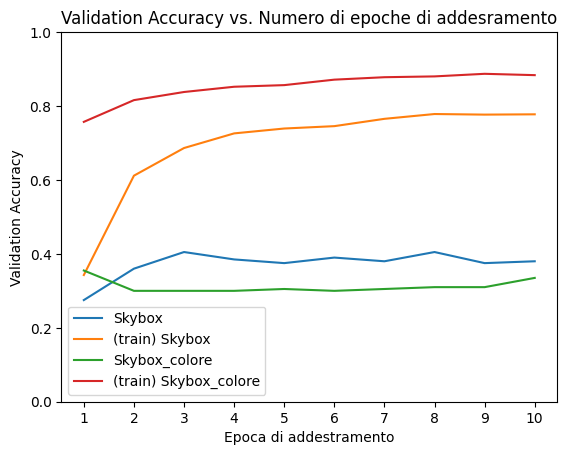

In [ ]:
# Grafico che rappresenta l'andamento della validation / training accuracy all'aumentare del numero delle epoche
ohist_ft_1 = []
ohist_ft_2 = []
ohist_ft_3 = []
ohist_ft_4 = []
ohist_ft_5 = []
ohist_ft_6 = []
ohist_ft_1 = [h.cpu().numpy() for h in hist_ft_1]
ohist_ft_2 = [h.cpu().numpy() for h in hist_ft_2]
ohist_ft_3 = [h.cpu().numpy() for h in hist_ft_3]
ohist_ft_4 = [h.cpu().numpy() for h in hist_ft_4]
ohist_ft_5 = [h.cpu().numpy() for h in hist_ft_5]
ohist_ft_6 = [h.cpu().numpy() for h in hist_ft_6]

ohist_ft_train_1 = []
ohist_ft_train_2 = []
ohist_ft_train_1 = []
ohist_ft_train_2 = []
ohist_ft_train_1 = []
ohist_ft_train_2 = []
ohist_ft_train_1 = [h.cpu().numpy() for h in hist_ft_train_1]
ohist_ft_train_2 = [h.cpu().numpy() for h in hist_ft_train_2]
ohist_ft_train_3 = [h.cpu().numpy() for h in hist_ft_train_3]
ohist_ft_train_4 = [h.cpu().numpy() for h in hist_ft_train_4]
ohist_ft_train_5 = [h.cpu().numpy() for h in hist_ft_train_5]
ohist_ft_train_6 = [h.cpu().numpy() for h in hist_ft_train_6]


fig, axs = plt.subplots(1, 2, figsize=(12, 6))                 # 1 riga, 2 colonne
step = num_epochs/10

# Grafico per la fase di val
axs[0].set_title("Validation Accuracy vs. Numero di epoche di addestramento")
axs[0].set_xlabel("Epoca di addestramento")
axs[0].set_ylabel("Validation Accuracy")

axs[0].plot(range(1, num_epochs+1), ohist_ft_1, label="Skybox")
axs[0].plot(range(1, num_epochs+1), ohist_ft_1, label="Skybox")
axs[0].plot(range(1, num_epochs+1), ohist_ft_2, label="Skybox_colore")
axs[0].plot(range(1, num_epochs+1), ohist_ft_3, label="Skybox-Colore_oggetto")
axs[0].plot(range(1, num_epochs+1), ohist_ft_4, label="Skybox-Material_oggetto")
axs[0].plot(range(1, num_epochs+1), ohist_ft_5, label="Skybox-Luci")
axs[0].plot(range(1, num_epochs+1), ohist_ft_6, label="Skybox-Luci-Material_oggetto")

axs[0].set_ylim((0,1.))
axs[0].set_xticks(np.arange(1, num_epochs+1, step))
axs[0].legend()
axs[0].grid()


# Grafico per la fase di train
axs[1].set_title("Training Accuracy vs. Numero di epoche di addestramento")
axs[1].set_xlabel("Epoca di addestramento")
axs[1].set_ylabel("Trainig Accuracy")

axs[1].plot(range(1,num_epochs+1), ohist_ft_train_1, label="Skybox")
axs[1].plot(range(1,num_epochs+1), ohist_ft_train_2, label="Skybox_colore")
axs[1].plot(range(1,num_epochs+1), ohist_ft_train_3, label="Skybox-Colore_oggetto")
axs[1].plot(range(1,num_epochs+1), ohist_ft_train_4, label="Skybox-Material_oggetto")
axs[1].plot(range(1,num_epochs+1), ohist_ft_train_5, label="Skybox-Luci")
axs[1].plot(range(1,num_epochs+1), ohist_ft_train_6, label="Skybox-Luci-Material_oggetto")

axs[1].set_ylim((0,1.))
axs[1].set_xticks(np.arange(1, num_epochs+1, step))
axs[1].legend()
axs[1].grid()


plt.show()            # per mostrare a schermo entrambi i grafici

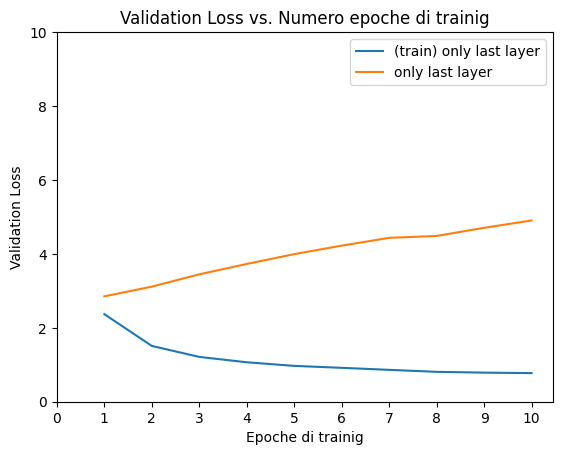

In [ ]:
# Grafico che rappresenta l'andamento della loss nel val e nel train all'aumentare del numero delle epoche
hist_loss_range_1 = np.arange((num_epochs)/len(hist_ftloss_1),num_epochs+((num_epochs)/len(hist_ftloss_1)),(num_epochs)/len(hist_ftloss_1))
hist_loss_range_2 = np.arange((num_epochs)/len(hist_ftloss_2),num_epochs+((num_epochs)/len(hist_ftloss_2)),(num_epochs)/len(hist_ftloss_2))
hist_loss_range_3 = np.arange((num_epochs)/len(hist_ftloss_3),num_epochs+((num_epochs)/len(hist_ftloss_3)),(num_epochs)/len(hist_ftloss_3))
hist_loss_range_4 = np.arange((num_epochs)/len(hist_ftloss_4),num_epochs+((num_epochs)/len(hist_ftloss_4)),(num_epochs)/len(hist_ftloss_4))
hist_loss_range_5 = np.arange((num_epochs)/len(hist_ftloss_5),num_epochs+((num_epochs)/len(hist_ftloss_5)),(num_epochs)/len(hist_ftloss_5))
hist_loss_range_6 = np.arange((num_epochs)/len(hist_ftloss_6),num_epochs+((num_epochs)/len(hist_ftloss_6)),(num_epochs)/len(hist_ftloss_6))

hist_loss_train_range_1 = np.arange((num_epochs)/len(hist_ftloss_train_1),num_epochs+((num_epochs)/len(hist_ftloss_train_1)),(num_epochs)/len(hist_ftloss_train_1))
hist_loss_train_range_2 = np.arange((num_epochs)/len(hist_ftloss_train_2),num_epochs+((num_epochs)/len(hist_ftloss_train_2)),(num_epochs)/len(hist_ftloss_train_2))
hist_loss_train_range_3 = np.arange((num_epochs)/len(hist_ftloss_train_3),num_epochs+((num_epochs)/len(hist_ftloss_train_3)),(num_epochs)/len(hist_ftloss_train_3))
hist_loss_train_range_4 = np.arange((num_epochs)/len(hist_ftloss_train_4),num_epochs+((num_epochs)/len(hist_ftloss_train_4)),(num_epochs)/len(hist_ftloss_train_4))
hist_loss_train_range_5 = np.arange((num_epochs)/len(hist_ftloss_train_5),num_epochs+((num_epochs)/len(hist_ftloss_train_5)),(num_epochs)/len(hist_ftloss_train_5))
hist_loss_train_range_6 = np.arange((num_epochs)/len(hist_ftloss_train_6),num_epochs+((num_epochs)/len(hist_ftloss_train_6)),(num_epochs)/len(hist_ftloss_train_6))


fig, axs = plt.subplots(1, 2, figsize=(12, 6))                 # 1 riga, 2 colonne
step = num_epochs/10

# Grafico per la fase di val
axs[0].set_title("Validation Loss vs. Numero di epoche di addestramento")
axs[0].set_xlabel("Epoca di addestramento")
axs[0].set_ylabel("Validation Loss")

axs[0].plot(hist_loss_range_1, hist_ftloss_1, label="Skybox")
axs[0].plot(hist_loss_range_2, hist_ftloss_2, label="Skybox_colore")
axs[0].plot(hist_loss_range_3, hist_ftloss_3, label="Skybox-Colore_oggetto")
axs[0].plot(hist_loss_range_4, hist_ftloss_4, label="Skybox-Material_oggetto")
axs[0].plot(hist_loss_range_5, hist_ftloss_5, label="Skybox-Luci")
axs[0].plot(hist_loss_range_6, hist_ftloss_6, label="Skybox-Luci-Material_oggetto")

axs[0].set_ylim((0,5.))
axs[0].set_xticks(np.arange(1, num_epochs+1, step))
axs[0].legend()
axs[0].grid()

# Grafico per la fase di train
axs[1].set_title("Training Loss vs. Numero di epoche di addestramento")
axs[1].set_xlabel("Epoca di addestramento")
axs[1].set_ylabel("Trainig Loss")

axs[1].plot(hist_loss_train_range_1, hist_ftloss_train_1, label="Skybox")
axs[1].plot(hist_loss_train_range_2, hist_ftloss_train_2, label="Skybox_colore")
axs[1].plot(hist_loss_train_range_3, hist_ftloss_train_3, label="Skybox-Colore_oggetto")
axs[1].plot(hist_loss_train_range_4, hist_ftloss_train_4, label="Skybox-Material_oggetto")
axs[1].plot(hist_loss_train_range_5, hist_ftloss_train_5, label="Skybox-Luci")
axs[1].plot(hist_loss_train_range_6, hist_ftloss_train_6, label="Skybox-Luci-Material_oggetto")

axs[1].set_ylim((0, 10.))
axs[1].set_xticks(np.arange(1, num_epochs+1, step))
axs[1].legend()
axs[1].grid()

plt.show()

# **PREDIZIONI DEI MODELLI**

In [ ]:
model_ft_1.eval()       # imposto i modelli in fase di valutazione, in modo da poter visualizzare le immagini reali
model_ft_2.eval()
model_ft_3.eval()
model_ft_4.eval()
model_ft_5.eval()
model_ft_6.eval()

labels_map = {
    0: "apple",
    1: "bleach_bottle",
    2: "bolt_cutters",
    3: "can_rusted",
    4: "crowbar",
    5: "dice",
    6: "drill",
    7: "flat_screwdriver",
    8: "garden_gloves",
    9: "hammer",
    10: "handsaw_wood",
    11: "leather_cleaner_can",
    12: "lemon",
    13: "lightbulb",
    14: "magneticlevel_low",
    15: "measuring_tape",
    16: "mousetrap",
    17: "safetyhat_low",
    18: "small_oil_can",
    19: "spatula",
}

In [ ]:
# Skybox di immagini
figure = plt.figure(figsize=(50, 50))
cols, rows = 10,
for i in range(1, cols * rows + 1):
    img, label = image_datasets_1['val'][i-1]
    figure.add_subplot(rows, cols, i)
    plt.imshow(copy.deepcopy(img).permute(1, 2, 0))

    img = img.to(device)
    outputs = model_ft(torch.unsqueeze(img,0))
    _, pred = torch.topk(outputs, 5, 1)
    pred = torch.squeeze(pred)
    tempLabel = labels_map[label] + ' => ' + labels_map[pred[0].item()] + ', ' + labels_map[pred[1].item()]

    plt.title(tempLabel)
    plt.axis("off")

plt.show()

In [ ]:
# Skybox monocolore
figure = plt.figure(figsize=(50, 50))
cols, rows = 10,
for i in range(1, cols * rows + 1):
    img, label = image_datasets_2['val'][i-1]
    figure.add_subplot(rows, cols, i)
    plt.imshow(copy.deepcopy(img).permute(1, 2, 0))

    img = img.to(device)
    outputs = model_ft(torch.unsqueeze(img,0))
    _, pred = torch.topk(outputs, 5, 1)
    pred = torch.squeeze(pred)
    tempLabel = labels_map[label] + ' => ' + labels_map[pred[0].item()] + ', ' + labels_map[pred[1].item()]

    plt.title(tempLabel)
    plt.axis("off")

plt.show()

In [ ]:
# Skybox di immagini / colore dell'oggetto
figure = plt.figure(figsize=(50, 50))
cols, rows = 10,
for i in range(1, cols * rows + 1):
    img, label = image_datasets_3['val'][i-1]
    figure.add_subplot(rows, cols, i)
    plt.imshow(copy.deepcopy(img).permute(1, 2, 0))

    img = img.to(device)
    outputs = model_ft(torch.unsqueeze(img,0))
    _, pred = torch.topk(outputs, 5, 1)
    pred = torch.squeeze(pred)
    tempLabel = labels_map[label] + ' => ' + labels_map[pred[0].item()] + ', ' + labels_map[pred[1].item()]

    plt.title(tempLabel)
    plt.axis("off")

plt.show()

In [ ]:
# Skybox di immagini / texture dell'oggetto
figure = plt.figure(figsize=(50, 50))
cols, rows = 10,
for i in range(1, cols * rows + 1):
    img, label = image_datasets_4['val'][i-1]
    figure.add_subplot(rows, cols, i)
    plt.imshow(copy.deepcopy(img).permute(1, 2, 0))

    img = img.to(device)
    outputs = model_ft(torch.unsqueeze(img,0))
    _, pred = torch.topk(outputs, 5, 1)
    pred = torch.squeeze(pred)
    tempLabel = labels_map[label] + ' => ' + labels_map[pred[0].item()] + ', ' + labels_map[pred[1].item()]

    plt.title(tempLabel)
    plt.axis("off")

plt.show()

In [ ]:
# Skybox di immagini / intensità, direzzione e colore delle luci
figure = plt.figure(figsize=(50, 50))
cols, rows = 10,
for i in range(1, cols * rows + 1):
    img, label = image_datasets_5['val'][i-1]
    figure.add_subplot(rows, cols, i)
    plt.imshow(copy.deepcopy(img).permute(1, 2, 0))

    img = img.to(device)
    outputs = model_ft(torch.unsqueeze(img,0))
    _, pred = torch.topk(outputs, 5, 1)
    pred = torch.squeeze(pred)
    tempLabel = labels_map[label] + ' => ' + labels_map[pred[0].item()] + ', ' + labels_map[pred[1].item()]

    plt.title(tempLabel)
    plt.axis("off")

plt.show()

In [ ]:
# Skybox di immagini / texture dell'oggetto / intensità, direzzione e colore delle luci
figure = plt.figure(figsize=(50, 50))
cols, rows = 10,
for i in range(1, cols * rows + 1):
    img, label = image_datasets_6['val'][i-1]
    figure.add_subplot(rows, cols, i)
    plt.imshow(copy.deepcopy(img).permute(1, 2, 0))

    img = img.to(device)
    outputs = model_ft(torch.unsqueeze(img,0))
    _, pred = torch.topk(outputs, 5, 1)
    pred = torch.squeeze(pred)
    tempLabel = labels_map[label] + ' => ' + labels_map[pred[0].item()] + ', ' + labels_map[pred[1].item()]

    plt.title(tempLabel)
    plt.axis("off")

plt.show()